# Get Current Forecast

read out the forecast for different companies for today. Source of forecast data is [https://kursprognose.com](https://kursprognose.com)

In [1]:
from finance_monitor.forecastgrapper import ForecastGrapper
fcg = ForecastGrapper()

Forecast data saved to 20250410_nvidia_forecast.csv
Forecast data saved to 20250410_nvidia_forecast.csv
Current stock price of nvidia is 107.57 USD / 96.06 EUR


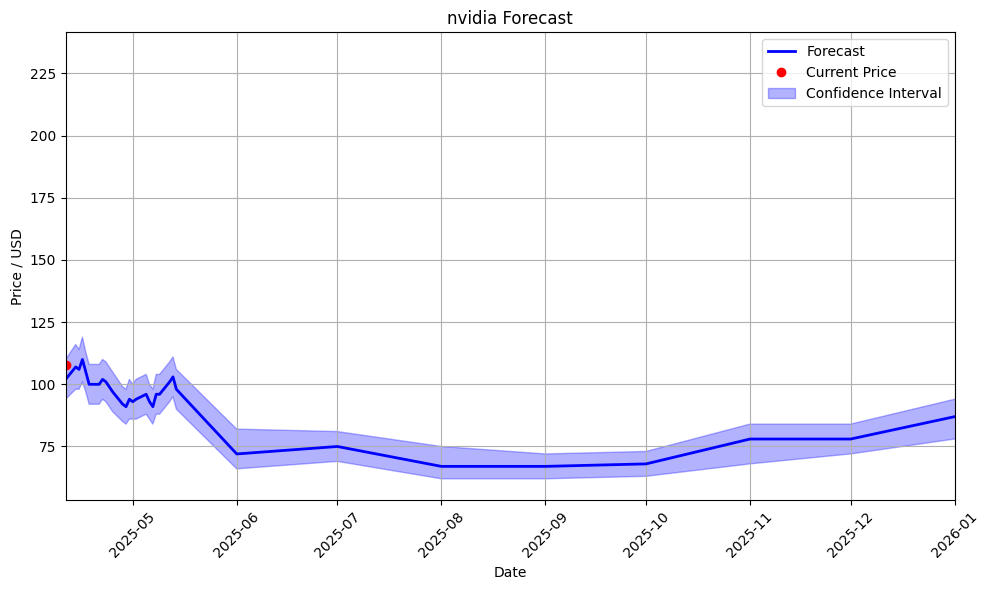

In [2]:
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250410_rhm-aktie_forecast.csv
Forecast data saved to 20250410_rhm-aktie_forecast.csv
Current stock price of rhm-aktie is 1520.0 USD / 1357.36 EUR


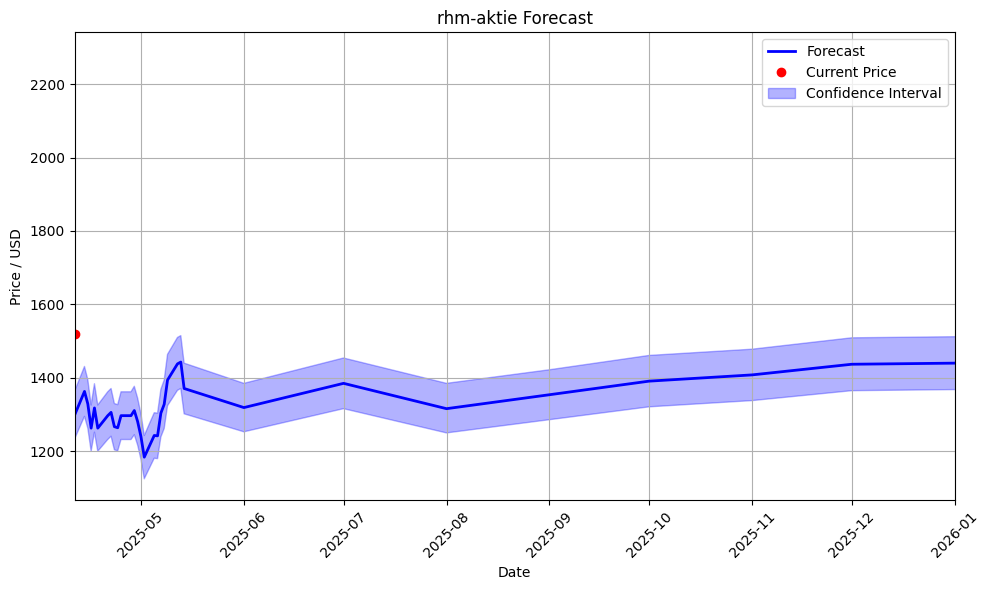

In [3]:
fcg.set_company("rhm-aktie")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250410_tesla_forecast.csv
Forecast data saved to 20250410_tesla_forecast.csv
Current stock price of tesla is 252.4 USD / 225.39 EUR


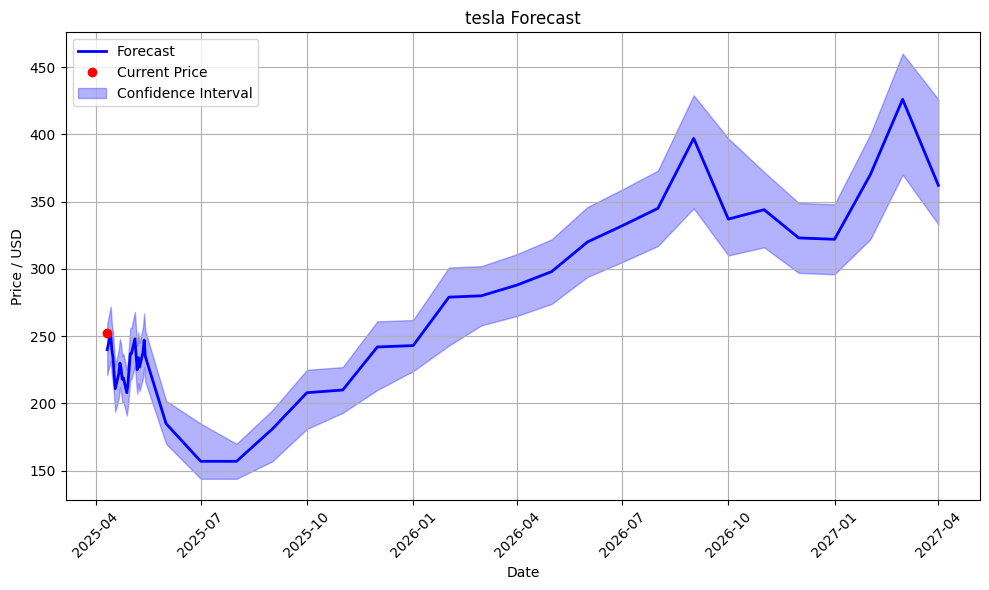

In [4]:
fcg.set_company("tesla")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250410_netflix_forecast.csv
Forecast data saved to 20250410_netflix_forecast.csv
Current stock price of netflix is 921.17 USD / 822.6 EUR


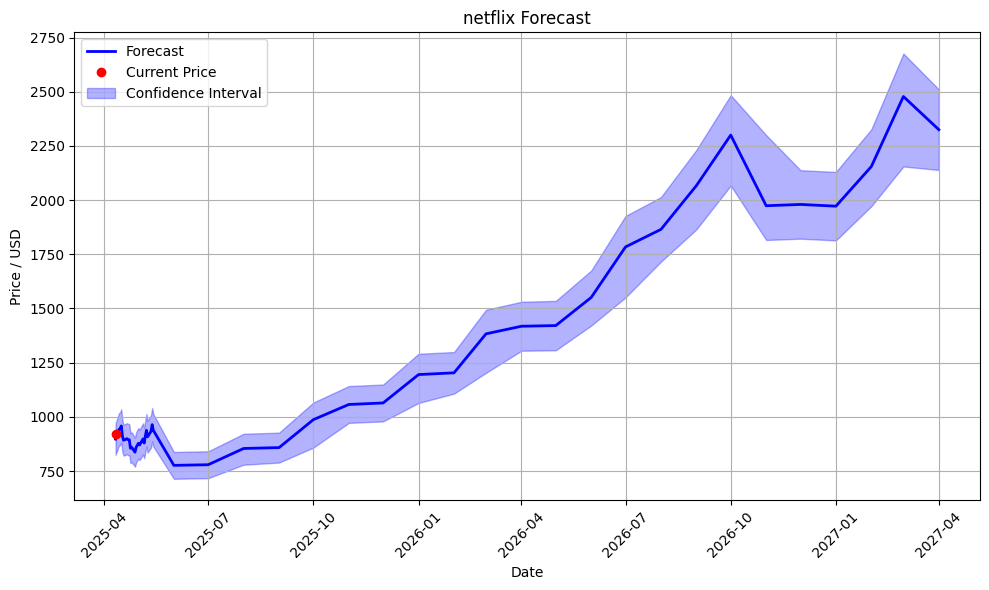

In [5]:
fcg.set_company("netflix")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250410_wmt-stock_forecast.csv
Forecast data saved to 20250410_wmt-stock_forecast.csv
Current stock price of wmt-stock is 90.61 USD / 80.91 EUR


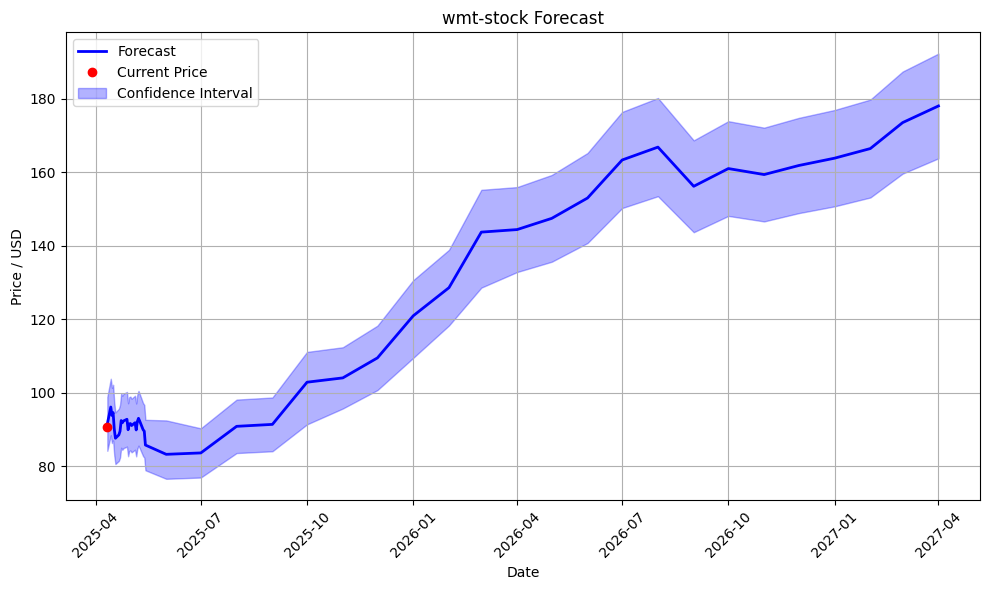

In [6]:
fcg.set_company("wmt-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250410_xpeng_forecast.csv
Forecast data saved to 20250410_xpeng_forecast.csv
Current stock price of xpeng is 17.97 USD / 16.05 EUR


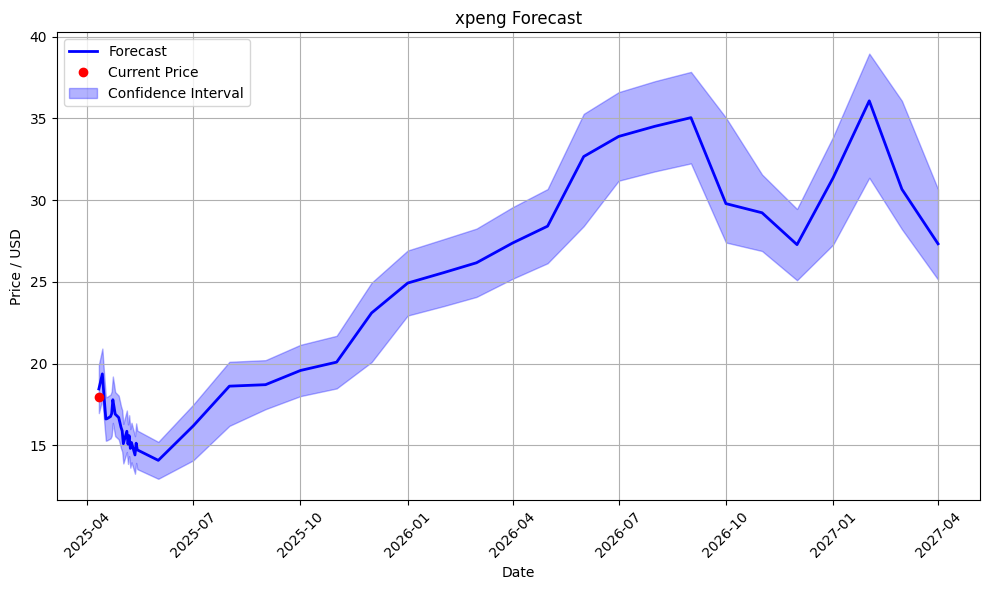

In [7]:
fcg.set_company("xpeng")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250410_mo-stock_forecast.csv
Forecast data saved to 20250410_mo-stock_forecast.csv
Current stock price of mo-stock is 56.38 USD / 50.35 EUR


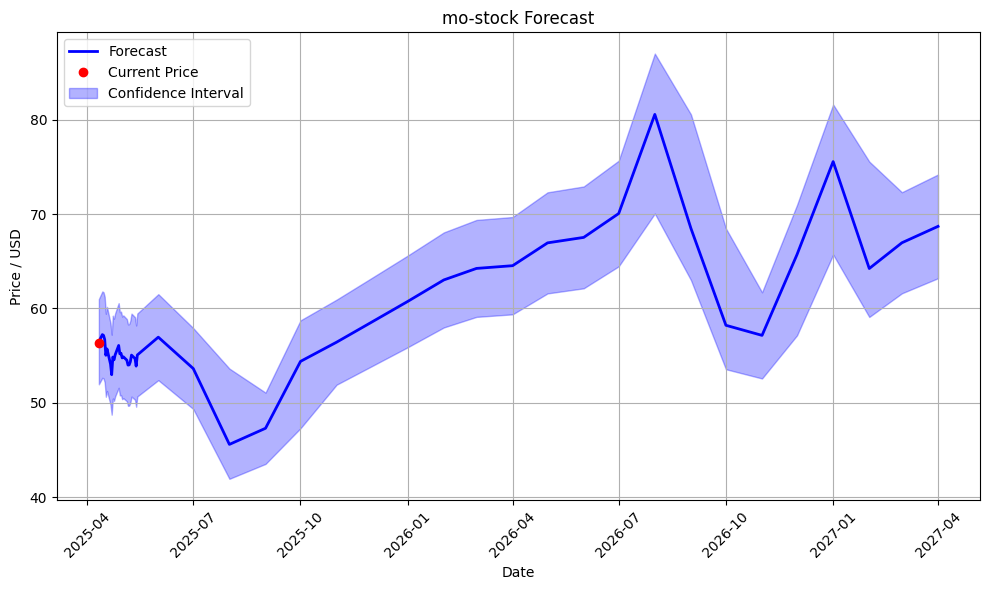

In [8]:
fcg.set_company("mo-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()